# CoCoScore Implementation

This notebook consists of implementing the [CoCoScore](https://www.biorxiv.org/content/10.1101/444398v1) literature model for comparison. We report performance as area under the precision recall curve (AUPR) and area under the receiver operating curve (AUROC). In both cases the greater the area the better the model is.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import defaultdict
import os
import sys

sys.path.append(os.path.abspath('../../../../modules'))

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, accuracy_score, confusion_matrix
from tqdm import tqdm_notebook

In [2]:
from utils.notebook_utils.dataframe_helper import load_candidate_dataframes

In [ ]:
total_candidates_df = pd.read_csv("input/all_gig_candidates.tsv.xz", sep="\t").sort_values("candidate_id")
total_candidates_df.head(2)

In [ ]:
spreadsheet_names = {
    'dev': '../../data/sentences/sentence_labels_dev.xlsx',
    'test': '../../data/sentences/sentence_labels_test.xlsx'
}

In [ ]:
candidate_dfs = {
    key:load_candidate_dataframes(spreadsheet_names[key], "curated_gig")
    for key in spreadsheet_names
}

for key in candidate_dfs:
    print("Size of {} set: {}".format(key, candidate_dfs[key].shape[0]))

In [ ]:
distant_supervision_marginals = pd.read_csv("input/baseline_sampled.tsv.xz", sep="\t")
distant_supervision_marginals.head(2)

In [ ]:
word_dict = pd.read_csv("input/gene_interacts_gene_word_dict.tsv", sep="\t").assign(index=lambda x: x.index + 2)
word_dict.head()

In [ ]:
reverse_word_dict = dict(zip(word_dict['index'].values.tolist(), word_dict.word))

train_marginal_dict = dict(zip(
    distant_supervision_marginals.candidate_id, 
    distant_supervision_marginals[distant_supervision_marginals.columns[0]]
))

tune_marginal_dict = dict(zip(
    candidate_dfs['dev'].candidate_id.values,
    candidate_dfs['dev'].curated_gig.values
))


test_marginal_dict = dict(zip(
    candidate_dfs['test'].candidate_id.values,
    candidate_dfs['test'].curated_gig.values
))

In [ ]:
data_rows = []
entity_one_start = word_dict.query("word=='~~[[1'")['index'].values[0]
entity_one_end = word_dict.query("word=='1]]~~'")['index'].values[0]

entity_two_start = word_dict.query("word=='~~[[2'")['index'].values[0]
entity_two_end = word_dict.query("word=='2]]~~'")['index'].values[0]

data = pd.read_csv(
    "input/all_embedded_gg_sentences.tsv.xz", 
    chunksize=1000000, sep="\t",
    iterator=True
)

with open("output/optimization_data/training.txt", "w") as train:
    with open("output/optimization_data/tune.txt", "w") as tune:
        with open("output/optimization_data/test.txt", "w") as test:
            with open("output/all_gg_sentences.txt", "w") as all_sen:
                for df in data:
                    for idx, sen_df in tqdm_notebook(df.iterrows()):
                        sen = sen_df.iloc[:-2].tolist()
                        try:
                            # remove entity mentions for coco_score
                            del sen[sen.index(entity_one_start): sen.index(entity_one_end)+1]
                            del sen[sen.index(entity_two_start): sen.index(entity_two_end)+1]

                            embedded_sen = list(map(
                                lambda x: reverse_word_dict[x] if x in reverse_word_dict else "UNK" if x == 1 else "",
                                sen
                            ))

                            cand_id = int(sen_df.iloc[-2])
                            if cand_id in train_marginal_dict:
                                train.write(
                                    f"__label__{'1' if train_marginal_dict[cand_id]> 0.5 else '0'}\t" +
                                    "\t".join(embedded_sen)+ 
                                    "\n"
                                )
                            if cand_id in tune_marginal_dict:
                                tune.write(
                                    f"__label__{int(tune_marginal_dict[cand_id])}\t" +
                                    "\t".join(embedded_sen)+ 
                                    "\n"
                                )
                            if cand_id in test_marginal_dict:
                                test.write(
                                    f"__label__{int(test_marginal_dict[cand_id])}\t" +
                                    "\t".join(embedded_sen)+ 
                                    "\n"
                                )

                            all_sen.write(
                                    f"__label__{cand_id}\t" +
                                    "\t".join(embedded_sen) + 
                                    "\n"
                                )

                        except ValueError:
                            print(idx)

In [10]:
os.system(
    "../../../../../fastText/fasttext supervised " + 
    "-input output/optimization_data/training.txt -output output/gig_model " +
    "-lr 0.005 -epoch 50 -dim 300 -wordNgrams 2" 
)

os.system(
    "../../../../../fastText/fasttext predict-prob "+
    "output/gig_model.bin output/optimization_data/tune.txt "+
    " > output/optimized_predictions/tune_predictions.tsv"
)

os.system(
    "../../../../../fastText/fasttext predict-prob "+
    "output/gig_model.bin output/optimization_data/test.txt "+
    " > output/optimized_predictions/test_predictions.tsv"
)

0

In [11]:
tune_df = (
    pd.read_csv(
        'output/optimized_predictions/tune_predictions.tsv', 
        header=None, sep=" ", 
        names=["label", "pred"]
    )
    .assign(label=lambda x: x.label.apply(lambda sen: sen[-1]))
)

precision, recall, _ = precision_recall_curve(
    tune_df.label.astype(int).values,
    1-tune_df.pred.values
)
auc(recall, precision)

0.3966689555850803

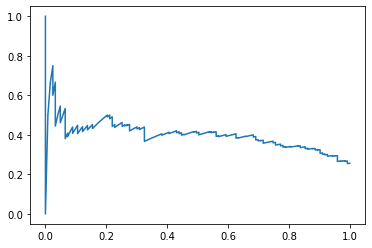

In [12]:
plt.plot(recall, precision)

In [13]:
fpr, tpr, _ = roc_curve(
    tune_df.label.astype(int).values,
    1-tune_df.pred.values
)
auc(fpr, tpr)

0.7383094043706395

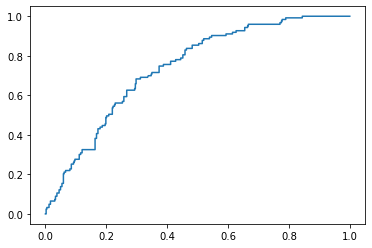

In [14]:
plt.plot(fpr, tpr)

In [17]:
os.system(
    "../../../../../fastText/fasttext predict-prob "+
    "output/gig_model.bin output/all_gg_sentences.txt "+
    "> output/all_gg_sentences_predictions.tsv"
)

0

In [20]:
cand_ids = []
with open("output/all_gg_sentences.txt", "r") as f:
    for line in tqdm_notebook(f):
        cand_ids.append(int(line.split("\t")[0].split("__")[2]))

/home/danich1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
predictions_df = (
    pd.read_csv(
        "output/all_gg_sentences_predictions.tsv", 
        header=None, sep=" ",
        names=["label", "coco_pred"]
    )
    .assign(candidate_id=cand_ids)
    .assign(coco_pred=lambda x: 1 - x.coco_pred)
    .assign(coco_pred=lambda x: x.coco_pred.clip(0,1) + 1e-5)
)
predictions_df.head(2)

,label,coco_pred,candidate_id
0,__label__0,0.033027,25627
1,__label__0,0.011065,25628


In [22]:
final_pred_df = (
    total_candidates_df
    [["gene1_id", "gene2_id", "candidate_id"]]
    .merge(predictions_df[["coco_pred", "candidate_id"]])
)
final_pred_df.head(2)

,gene1_id,gene2_id,candidate_id,coco_pred
0,2796,2796,25627,0.033027
1,3976,3976,25628,0.011065


In [23]:
added_scores_df = (
    final_pred_df
    .groupby(["gene1_id", "gene2_id"])
    .aggregate({"coco_pred": 'sum'})
    .reset_index()
)
added_scores_df.head(2)

,gene1_id,gene2_id,coco_pred
0,1,1,20.297067
1,1,2,0.121055


In [24]:
total_score = added_scores_df.coco_pred.sum()
gene_scores = added_scores_df.groupby("gene1_id").agg({"coco_pred":"sum"}).reset_index()
gene_scores = dict(zip(gene_scores.gene1_id, gene_scores.coco_pred))
drug_scores = added_scores_df.groupby("gene2_id").agg({"coco_pred":"sum"}).reset_index()
drug_scores = dict(zip(drug_scores.gene2_id, drug_scores.coco_pred))

alpha=0.65

final_scores_df = added_scores_df.assign(
    final_score=(
        added_scores_df.apply(
            lambda x: pd.np.exp(
                    alpha*pd.np.log(x['coco_pred']) + (1-alpha)*(
                    pd.np.log(x['coco_pred']) + pd.np.log(total_score) - 
                    pd.np.log(gene_scores[x['gene1_id']]) - pd.np.log(drug_scores[x['gene2_id']])
                )
            ), 
            axis=1
        )
    )
)
final_scores_df.head(2)

,gene1_id,gene2_id,coco_pred,final_score
0,1,1,20.297067,211.277869
1,1,2,0.121055,0.393441


In [25]:
score_with_labels_df = (
    final_scores_df
    .merge(
        total_candidates_df[["gene1_id", "gene2_id", "hetionet"]],
        on=["gene1_id", "gene2_id"]
    )
    .drop_duplicates()
)
score_with_labels_df.head(2)

,gene1_id,gene2_id,coco_pred,final_score,hetionet
0,1,1,20.297067,211.277869,0
240,1,2,0.121055,0.393441,0


In [26]:
(
    score_with_labels_df
    .drop("coco_pred", axis=1)
    .rename({"final_score": "coco_score"})
    .to_csv("output/gg_edge_prediction_cocoscore.tsv", sep="\t", index=False)
)

In [27]:
fpr, tpr, _ = roc_curve(score_with_labels_df.hetionet, score_with_labels_df.final_score)
print(auc(fpr, tpr))

precision, recall, _ = precision_recall_curve(score_with_labels_df.hetionet, score_with_labels_df.final_score)
print(auc(recall, precision))

0.7757905827903091
0.12373428012942868
